In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-hiring-decisions-in-recruitment-data/recruitment_data.csv


For this project, I'll be doing some Exploratory Data Analysis and then testing different prediction methods on this recruitment dataset. 

In [2]:
df = pd.read_csv("/kaggle/input/predicting-hiring-decisions-in-recruitment-data/recruitment_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   Gender               1500 non-null   int64  
 2   EducationLevel       1500 non-null   int64  
 3   ExperienceYears      1500 non-null   int64  
 4   PreviousCompanies    1500 non-null   int64  
 5   DistanceFromCompany  1500 non-null   float64
 6   InterviewScore       1500 non-null   int64  
 7   SkillScore           1500 non-null   int64  
 8   PersonalityScore     1500 non-null   int64  
 9   RecruitmentStrategy  1500 non-null   int64  
 10  HiringDecision       1500 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 129.0 KB


In [4]:
df.describe()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,35.148667,0.492000,2.188000,7.694000,3.00200,25.505379,50.564000,51.116000,49.387333,1.893333,0.310000
std,9.252728,0.500103,0.862449,4.641414,1.41067,14.567151,28.626215,29.353563,29.353201,0.689642,0.462647
min,20.000000,0.000000,1.000000,0.000000,1.00000,1.031376,0.000000,0.000000,0.000000,1.000000,0.000000
25%,27.000000,0.000000,2.000000,4.000000,2.00000,12.838851,25.000000,25.750000,23.000000,1.000000,0.000000
50%,35.000000,0.000000,2.000000,8.000000,3.00000,25.502239,52.000000,53.000000,49.000000,2.000000,0.000000
75%,43.000000,1.000000,3.000000,12.000000,4.00000,37.737996,75.000000,76.000000,76.000000,2.000000,1.000000
max,50.000000,1.000000,4.000000,15.000000,5.00000,50.992462,100.000000,100.000000,100.000000,3.000000,1.000000


In [5]:
df.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


# EDA

In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import keras
from keras import models
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import layers
from tensorflow.keras.layers import Dense, InputLayer

2024-06-23 00:09:41.132425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 00:09:41.132636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 00:09:41.344628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  0


<Figure size 600x600 with 0 Axes>

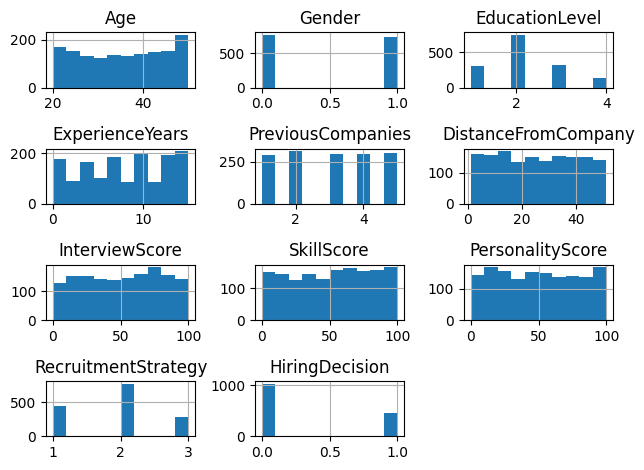

In [7]:
plt.figure(figsize=(6,6))
df.hist()
plt.tight_layout()
plt.show()

In [8]:
df.columns

Index(['Age', 'Gender', 'EducationLevel', 'ExperienceYears',
       'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore',
       'SkillScore', 'PersonalityScore', 'RecruitmentStrategy',
       'HiringDecision'],
      dtype='object')

In [9]:
num_cols = ['Age', 'ExperienceYears', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore']

cat_cols = ['Gender', 'RecruitmentStrategy', 'PreviousCompanies']

ord_cols = ['EducationLevel']

target = ['HiringDecision']

In [10]:
def plot_histograms(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(4, 2))
        plt.hist(df[col], bins=25, color='lightgreen', edgecolor='black')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

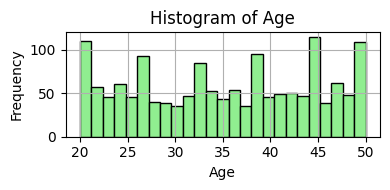

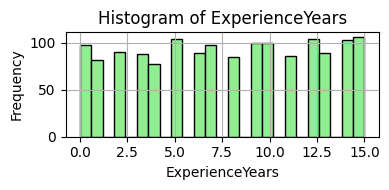

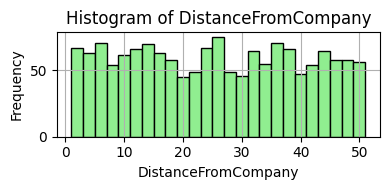

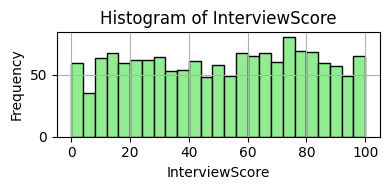

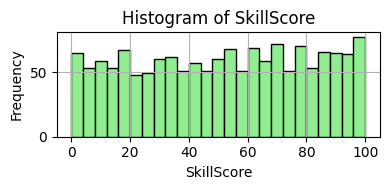

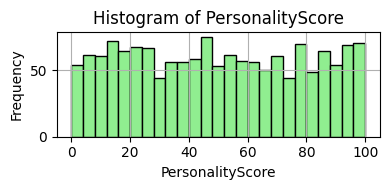

In [11]:
plot_histograms(df, num_cols)

In [12]:
def plot_boxplots(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(4, 2))
        sns.boxplot(x=df[col], color='red')
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.grid(True)
        plt.show()

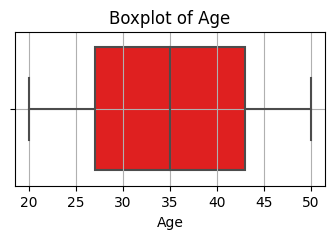

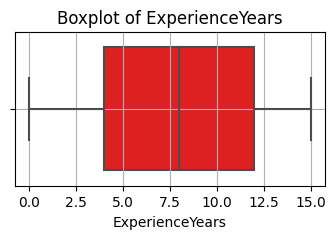

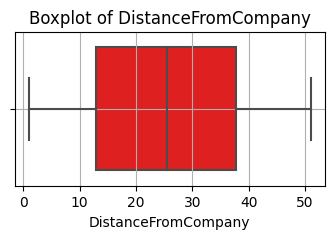

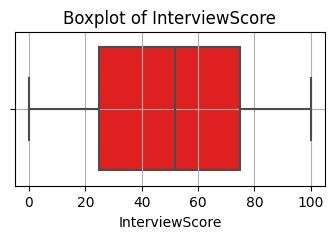

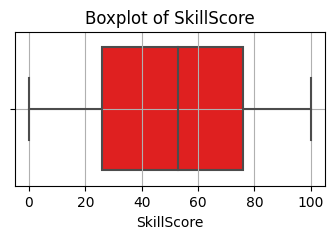

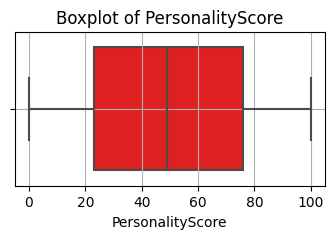

In [13]:
plot_boxplots(df, num_cols)

In [14]:
def create_bargraphs(data, cat_cols):
    for col in cat_cols:
        data[col] = pd.Categorical(data[col], ordered=True)
        category_counts = data[col].value_counts().sort_index()
        plt.figure(figsize=(6, 4))
        category_counts.plot(kind='bar')
        plt.title(f'Bar Graph for {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.xticks(rotation=90, fontsize=6)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

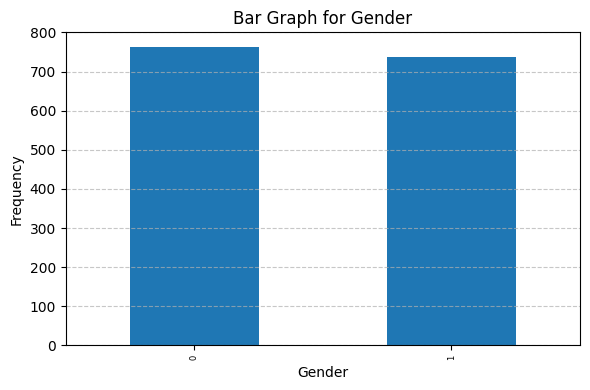

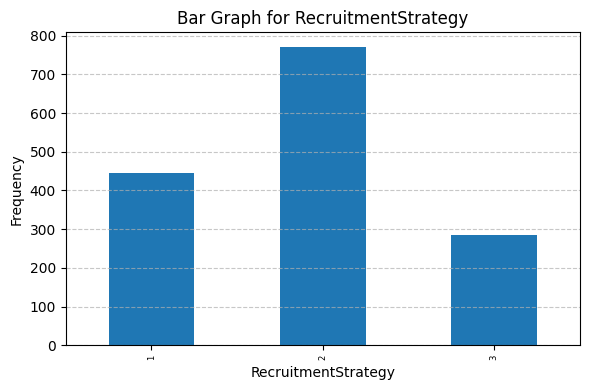

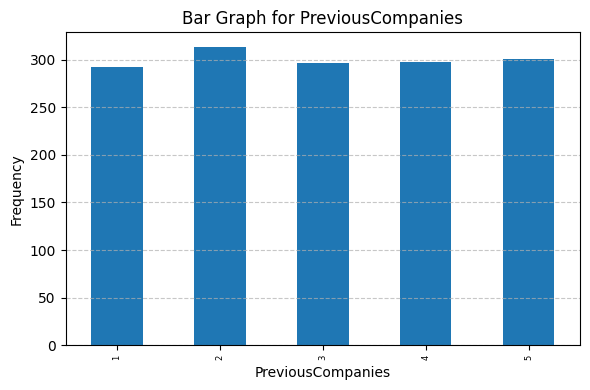

In [15]:
create_bargraphs(df, cat_cols)

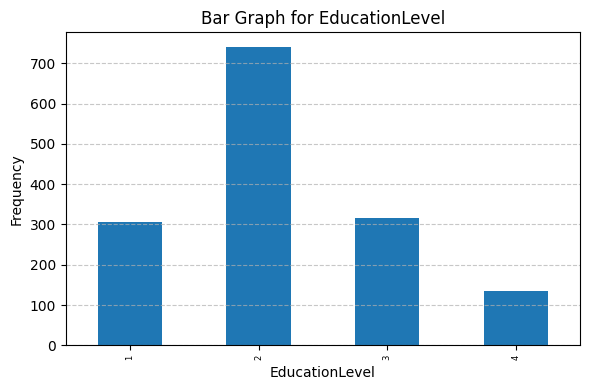

In [16]:
create_bargraphs(df, ord_cols)

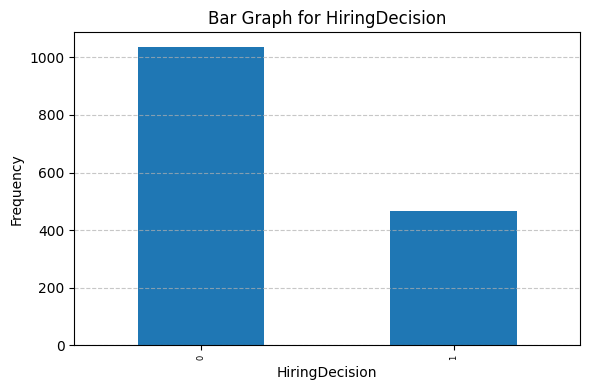

In [17]:
create_bargraphs(df, target)

In [18]:
pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).head(20)

,0
Age,0
Gender,0
EducationLevel,0
ExperienceYears,0
PreviousCompanies,0
DistanceFromCompany,0
InterviewScore,0
SkillScore,0
PersonalityScore,0
RecruitmentStrategy,0


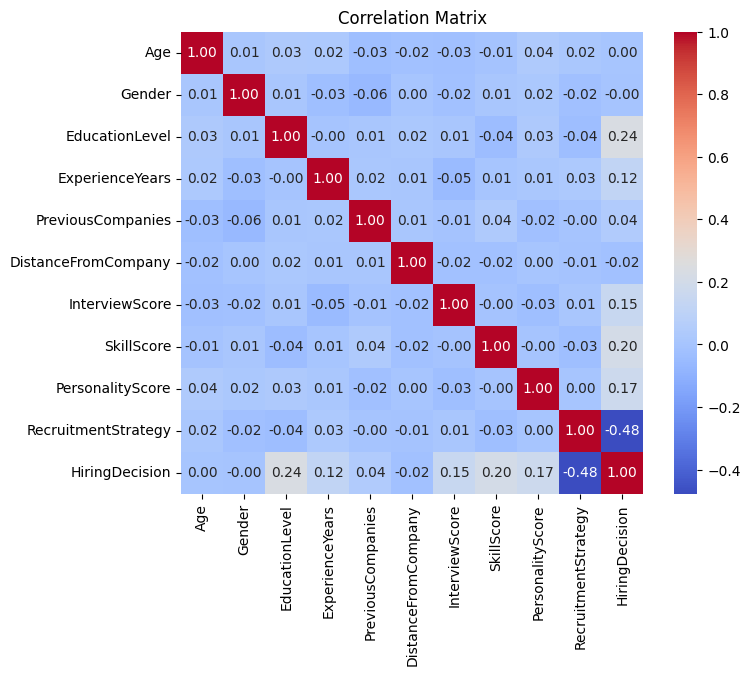

In [19]:
correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

From our correlation matrix we see the most correlated features to our target are: EducationLevel, ExperienceYears, InterviewScore, SkillScore, PersonalityScore, and RecruitmentStrategy

When feature engineering we could likely drop the other columns that do not have as high of a correlation to our target

# Pipeline

In [20]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [21]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ord_cols),
    ('ohe_p', ohe_pipeline, cat_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [22]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

# Splitting

In [23]:
X = df.drop(columns=['HiringDecision'], axis=1)
y = df['HiringDecision'].astype(int)

In [24]:
X_preprocessed = pipeline.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.15, random_state=25)

# ML Model Building

**Random Forest Classification**

In [26]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

rfc_acc = accuracy_score(y_test, rfc_pred)

print("Accuracy: ", rfc_acc)

print(classification_report(y_test, rfc_pred))

Accuracy:  0.8977777777777778
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       150
           1       0.92      0.76      0.83        75

    accuracy                           0.90       225
   macro avg       0.90      0.86      0.88       225
weighted avg       0.90      0.90      0.90       225



**SGDClassifier**

In [27]:
sgd = SGDClassifier()

sgd.fit(X_train, y_train)

sgd_pred = sgd.predict(X_test)

sgd_acc = accuracy_score(y_test, sgd_pred)

print("Accuracy: ", sgd_acc)

print(classification_report(y_test, sgd_pred))

Accuracy:  0.8533333333333334
              precision    recall  f1-score   support

           0       0.85      0.94      0.90       150
           1       0.85      0.68      0.76        75

    accuracy                           0.85       225
   macro avg       0.85      0.81      0.83       225
weighted avg       0.85      0.85      0.85       225



**CatBoostClassification**

In [28]:
cbc = CatBoostClassifier(verbose=0)

cbc.fit(X_train, y_train)

cbc_pred = cbc.predict(X_test)

cbc_acc = accuracy_score(y_test, cbc_pred)

print("Accuracy: ", cbc_acc)

print(classification_report(y_test, cbc_pred))

Accuracy:  0.96
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       150
           1       0.99      0.89      0.94        75

    accuracy                           0.96       225
   macro avg       0.97      0.94      0.95       225
weighted avg       0.96      0.96      0.96       225



In [29]:
param_grid_cbc ={
    'iterations': [50, 100, 500, 1000],
    'depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

In [30]:
cbc_cv = GridSearchCV(cbc, param_grid_cbc, cv=3, scoring='accuracy', n_jobs=-1)

cbc_cv.fit(X_train, y_train)

print("Best Score: ", cbc_cv.best_score_)
print("Best Parameters: ", cbc_cv.best_params_)

Best Score:  0.9584313725490196
Best Parameters:  {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}


In [31]:
best_cbc = cbc_cv.best_estimator_

best_cbc_pred = best_cbc.predict(X_test)

print(classification_report(y_test, best_cbc_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       150
           1       0.97      0.89      0.93        75

    accuracy                           0.96       225
   macro avg       0.96      0.94      0.95       225
weighted avg       0.96      0.96      0.96       225



# Deep Neural Network

In [32]:
model = models.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,450 (9.57 KB)

 Trainable params: 2,450 (9.57 KB)

 Non-trainable params: 0 (0.00 B)

None


In [33]:
es = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=15)

#history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.15, verbose=0, callbacks=[es])

history = model.fit(X_train, y_train, epochs=20, batch_size=25, validation_split=0.15, verbose=0)

test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Test accuracy: {test_acc}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8496 - loss: 0.4055 
Test accuracy: 0.8533333539962769


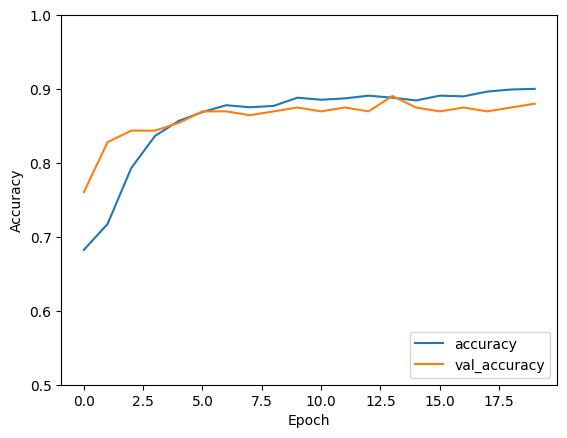

In [34]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [35]:
dnn_pred = model.predict(X_test)

dnn_pred = np.argmax(dnn_pred, axis=1)

print(classification_report(y_test, dnn_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       150
           1       0.79      0.76      0.78        75

    accuracy                           0.85       225
   macro avg       0.84      0.83      0.83       225
weighted avg       0.85      0.85      0.85       225



# Conclusion

Overall, the best model so far for this dataset is a default CatBoostClassifier as it beat the CV Search CatBoost in Precision and thus F-1 Score for our Hired class. For further testing, I'd like to improve my Deep Learning models predictability as well as use Optuna to see if the CatBoost model has some better hyperparameters that I could be using to beat my current accuracy score for both target classes. I'd also likely test what happens when I drop the uncorrelated features from the data set and maybe do some feature engineering to have more robust models. 